In [1]:
TARGET_AXIS = 'X'
assert TARGET_AXIS in ('X', 'Z', 'B', 'C')b

SELECT_VARS = False

In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, TimeSeriesSplit
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv("ITPAero_dataset.csv", sep=';')
df['FBrochado'] = pd.to_datetime(df['FBrochado'])

In [4]:
df['target'] = df[f'{TARGET_AXIS}CMM'] + df[f'{TARGET_AXIS}C']

df['targetX'] = df[f'XCMM'] + df[f'XC']
df['targetZ'] = df[f'ZCMM'] + df[f'ZC']
df['targetB'] = df[f'BCMM'] + df[f'BC']
df['targetC'] = df[f'CCMM'] + df[f'CC']

In [5]:
df = df[df.target.isna() == False]

In [6]:
def time_series_feature_engineering(df):
    """
    Perform feature engineering on time series data.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    target_column (str): Name of the target variable column
    date_column (str): Name of the date column
    window_sizes (list): List of rolling window sizes (default: [7, 14, 30])
    
    Returns:
    pd.DataFrame: DataFrame with new engineered features
    """
    
    for window in [1, 2, 3, 7, 14, 30]:
        # Rolling mean
        df[f'{group}{target_column}_rolling_mean{window}'] = df[target_column].rolling(window=window).mean().shift(1)
        
        # Rolling standard deviation
        df[f'{group}{target_column}_rolling_std{window}'] = df[target_column].rolling(window=window).std().shift(1)
        
        # Rolling median
        df[f'{group}{target_column}_rolling_median{window}'] = df[target_column].rolling(window=window).median().shift(1)
        
        # Rolling min
        df[f'{group}{target_column}_rolling_min{window}'] = df[target_column].rolling(window=window).min().shift(1)
        
        # Rolling max
        df[f'{group}{target_column}_rolling_max{window}'] = df[target_column].rolling(window=window).max().shift(1)
        
        # Rolling skewness
        df[f'{group}{target_column}_rolling_skew{window}'] = df[target_column].rolling(window=window).skew().shift(1)
        
        # Rolling kurtosis
        df[f'{group}{target_column}_rolling_kurtosis{window}'] = df[target_column].rolling(window=window).kurt().shift(1)
        
        # Exponential moving average
        df[f'{group}{target_column}_ema{window}'] = df[target_column].ewm(span=window, adjust=False).mean().shift(1)
    
    # Lag features
    for lag in [1, 2, 3, 7, 14, 30]:
        df[f'{group}{target_column}_lag{lag}'] = df[target_column].shift(lag)
    
    # Reset index to bring date column back
#    df = df.reset_index(drop)
    
    return df

df["BrochaSN_Utillaje"] = str(df["BrochaSN"]) + str(df[" Utillaje"])
df["Brocha_Utillaje"] = str(df["Brocha"]) + str(df[" Utillaje"])
df["BrochaSN_NBrochasHSS"] = str(df["BrochaSN"]) + str(df["NBrochasHSS"])
df["BrochaSN_ndisco"] = str(df["BrochaSN"]) + str(df["NDisco"])
df["Brocha_ndisco"] = str(df["Brocha"]) + str(df["NDisco"])
df["Maquina_BrochaSN_NBrochasHSS"] = str(df["Maquina"]) + str(df["BrochaSN_NBrochasHSS"])
df["Maquina_BrochaSN"] = str(df["Maquina"]) + str(df["BrochaSN"])


for target_column in ['target']:#['targetX', 'targetZ', 'targetB', 'targetC']:
    for group in ['BrochaSN_Utillaje',
                  'Maquina',
                  ' Utillaje', 
                  'Brocha',
                  'Brocha_ndisco',
                  'Maquina_BrochaSN',
                  'BrochaSN_ndisco',
                  'BrochaSN',
                  'BrochaSN_NBrochasHSS',
                  'Brocha_Utillaje',
                  'Maquina_BrochaSN_NBrochasHSS']:

        df = df.groupby(group, group_keys=False).apply(time_series_feature_engineering)

In [7]:
# Convert all object columns to categorical
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

In [8]:
train_idx = df['FBrochado'] < '2024-7-1'
test_idx = df['FBrochado'] >= '2024-7-1'

In [9]:
df['FBrochado'] = df['FBrochado'].astype('int')

In [10]:
# Important after FE
df = df[df.DUMMY == 'FALSO']

In [11]:
df = df.drop(columns=[
    'XCMM',
    'ZCMM',
    'BCMM',
    'CCMM',
    'BrochaSN',
    'PartNumber',
    'FBrochado',
    'XC',
    'ZC',
    'BC',
    'CC',
    'OrdenFabricacion'])

In [12]:
selected_vars = ['BrochaSNtarget_lag1', ' Utillajetarget_lag1',
       'BrochaSNtarget_ema7', 'BrochaSNtarget_rolling_skew3', ' Utillaje',
       'BrochaSNtarget_rolling_max7', 'BrochaSNtarget_ema14',
       'BrochaSNtarget_ema3', 'Maquinatarget_rolling_min3', 'Maquina',
       'BrochaSNtarget_rolling_median3', 'Brochatarget_ema3',
       'BrochaSNtarget_rolling_max3', ' Utillajetarget_ema3',
       ' Utillajetarget_ema30', 'NDisco', 'BrochaSNtarget_rolling_min7',
       'BrochaSNtarget_ema30', 'BrochaSNtarget_rolling_skew7',
       'Maquinatarget_rolling_min30', 'Brocha', 'Brochatarget_lag1',
       'Brochatarget_rolling_max3', 'BrochaSNtarget_rolling_min3',
       ' Utillajetarget_ema14', ' Utillajetarget_rolling_max7',
       'Brochatarget_rolling_max7', 'BrochaSNtarget_rolling_max14',
       ' Utillajetarget_rolling_min3', 'Maquinatarget_rolling_std30',
       'BrochaSNtarget_lag7', ' Utillajetarget_ema7', 'TpoIndexador',
       'Brochatarget_rolling_std3', ' Utillajetarget_rolling_min14',
       'Brochatarget_rolling_min3', 'Maquinatarget_lag14', 'NBrochaHSS',
       'Maquinatarget_rolling_min7', 'Maquinatarget_ema7',
       'Maquinatarget_lag30', 'BrochaSNtarget_rolling_min14',
       ' Utillajetarget_rolling_max14', 'Brochatarget_rolling_std14',
       'Maquinatarget_rolling_mean7', ' Utillajetarget_rolling_median14',
       ' Utillajetarget_rolling_std30', 'Maquinatarget_ema30',
       'Maquinatarget_rolling_mean30', 'BrochaSNtarget_rolling_mean7',
       'BrochaSNtarget_rolling_std7', ' Utillajetarget_rolling_median30',
       ' Utillajetarget_rolling_min30', 'Maquinatarget_rolling_max7',
       ' Utillajetarget_rolling_min7', 'Maquinatarget_ema14',
       ' Utillajetarget_rolling_max3', 'BrochaSNtarget_rolling_mean14',
       'BrochaSNtarget_rolling_std14', ' Utillajetarget_lag3',
       ' Utillajetarget_rolling_std3', ' Utillajetarget_rolling_skew3',
       ' Utillajetarget_rolling_mean30', 'BrochaSN_Utillajetarget_lag14',
       'BrochaSNtarget_rolling_mean3', 'Brochatarget_rolling_max14',
       'Maquinatarget_rolling_mean3', 'BrochaSNtarget_rolling_std3',
       'BrochaSNtarget_lag3', ' Utillajetarget_lag7',
       'BrochaSNtarget_rolling_skew14',
       ' Utillajetarget_rolling_kurtosis7', 'Brochatarget_lag30',
       ' Utillajetarget_lag14', 'Brochatarget_rolling_mean3',
       'Maquinatarget_rolling_std14',
       'BrochaSN_Utillajetarget_rolling_kurtosis7',
       'Maquinatarget_rolling_min14', 'Maquinatarget_rolling_skew3',
       'Maquinatarget_rolling_median14', 'Maquinatarget_rolling_max30',
       'Brochatarget_ema7', 'Brochatarget_rolling_kurtosis7',
       ' Utillajetarget_rolling_mean14',
       'BrochaSN_Utillajetarget_rolling_kurtosis30',
       'BrochaSNtarget_rolling_median7', 'BrochaSNtarget_lag14',
       'Maquinatarget_rolling_median30', 'Brochatarget_rolling_median30',
       'Brocha_ndiscotarget_lag14', 'BrochaSNtarget_rolling_min30',
       'Brochatarget_rolling_skew30', 'Brochatarget_rolling_mean14',
       'Brochatarget_ema14', 'BrochaSN_Utillajetarget_lag30',
       ' Utillajetarget_rolling_std14', ' Utillajetarget_rolling_median7',
       'Maquinatarget_ema3', 'Brochatarget_rolling_kurtosis30',
       'Brochatarget_rolling_min14']

In [13]:
df_train = df[train_idx]
df_test = df[test_idx]

/var/folders/th/h_b6fb4s5kx77mr9j442kbh80000gn/T/ipykernel_91923/1766937709.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df[train_idx]
/var/folders/th/h_b6fb4s5kx77mr9j442kbh80000gn/T/ipykernel_91923/1766937709.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = df[test_idx]


In [15]:
y = df_train['target']
y_test = df_test['target']

if SELECT_VARS:
    X = df_train.drop(columns=['target', 'targetX', 'targetZ', 'targetB', 'targetC'])[selected_vars]
    X_test = df_test.drop(columns=['target', 'targetX', 'targetZ', 'targetB', 'targetC'])[selected_vars]
else:
    X = df_train.drop(columns=['target', 'targetX', 'targetZ', 'targetB', 'targetC'])
    X_test = df_test.drop(columns=['target', 'targetX', 'targetZ', 'targetB', 'targetC'])

In [16]:
cat_cols = X.dtypes[X.dtypes == 'category'].index.tolist()

In [17]:
class VotingModel(BaseEstimator, RegressorMixin):
    #weights = np.arange(1, len(y_preds) + 1)
    #weights = np.ones_like(y_preds)
    #weights = np.exp(np.linspace(0, 2, len(y_preds)))
    #weights = np.linspace(1, len(y_preds), len(y_preds)) ** 2
    #weights = np.linspace(1, len(y_preds), len(y_preds)) ** 3
    #weights = np.linspace(1, len(y_preds), len(y_preds)) ** 4
    #weights = np.linspace(1, len(y_preds), len(y_preds)) ** 5


    #weights = np.log(np.linspace(1, len(y_preds) + 1, len(y_preds)))
    #x = np.linspace(-6, 6, len(y_preds))
    #weights = 1 / (1 + np.exp(-x))

    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict_sep(self, X):
        y_preds_lgbm = [estimator['lgbm'].predict(X) for estimator in self.estimators]
        y_preds_xgb = [estimator['xgb'].predict(X) for estimator in self.estimators]
        y_preds_cat = [estimator['cat'].predict(X) for estimator in self.estimators]

        
        weights = np.linspace(1, len(y_preds_cat), len(y_preds_cat)) ** 5

        lgbm_avg = np.average(y_preds_lgbm, weights=weights, axis=0)
        xgb_avg = np.average(y_preds_xgb, weights=weights, axis=0)
        cat_avg = np.average(y_preds_cat, weights=weights, axis=0)

        return lgbm_avg, xgb_avg, cat_avg
    

    def predict(self, X):
        y_preds_lgbm = [estimator['lgbm'].predict(X) for estimator in self.estimators]
        y_preds_xgb = [estimator['xgb'].predict(X) for estimator in self.estimators]
        y_preds_cat = [estimator['cat'].predict(X) for estimator in self.estimators]

        y_preds = np.mean([y_preds_lgbm, y_preds_cat], axis=0)
        
        weights = np.linspace(1, len(y_preds), len(y_preds)) ** 5

        return np.average(y_preds, weights=weights, axis=0)

In [18]:
def train(params):
    n_splits = 10
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=100)
    fitted_models = []
    rmses = []
    max_abss = []

    for i, (train_index, test_index) in enumerate(tqdm(tscv.split(X), total=n_splits)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_valid, y_valid = X.iloc[test_index], y.iloc[test_index]

        modelLGBM = lgb.LGBMRegressor(**params)
        modelXGB = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=1000,
            max_depth=4,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            enable_categorical=True,
            early_stopping_rounds=50
        )
        
        modelCat = CatBoostRegressor(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            loss_function='RMSE',
            eval_metric='RMSE',
            random_seed=0,
            early_stopping_rounds=50,
            verbose=0
        )

        modelCat.fit(
            X_train,
            y_train,
            eval_set=(X_valid, y_valid),
            use_best_model=True,
            cat_features=cat_cols,
            verbose=0
        )

        modelXGB.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        modelLGBM.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            #callbacks=[lgb.log_evaluation(200), lgb.early_stopping(60)]
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        
        fitted_models.append({'lgbm': modelLGBM, 'xgb': modelXGB, 'cat': modelCat})

        y_pred_valid = np.mean([modelLGBM.predict(X_valid), 
                                modelXGB.predict(X_valid)], axis=0)
        rmse = root_mean_squared_error(y_valid, y_pred_valid)
        max_abs = max(abs(y_valid - y_pred_valid))
        rmses.append(rmse)
        max_abss.append(max_abs)

    model = VotingModel(fitted_models)

    return model, rmses, max_abss

# Polbo galego

In [19]:
import joblib

# Create or load the study
def create_or_load_study(study_name, storage=None):
    try:
        study = joblib.load(f"optuna/{study_name}.pkl")
        print(f"Loaded study '{study_name}' from file.")
    except FileNotFoundError:
        study = optuna.create_study(study_name=study_name, storage=storage, direction='maximize')
        print(f"Created new study '{study_name}'.")
    return study

# Function to save the study
def save_study(study, study_name):
    joblib.dump(study, f"optuna/{study_name}.pkl")
    print(f"Study '{study_name}' saved to file.")

In [20]:
def objective(trial):
    # set up the parameters to be optimized
    param = {
        'metric': 'rmse', 
        #'random_state': seed,
        'n_estimators': 10000,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0,log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0,log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2,log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'num_leaves': trial.suggest_int('num_leaves', 40, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'cat_smooth': trial.suggest_int('cat_smooth', 1, 100),
        'force_col_wise':True,
        'min_data_in_leaf': 30,
        'verbose': -1
    }

    model, rmses, max_abss = train(param)
    #y_pred = model.predict(X_test,)
    #return root_mean_squared_error(y_test, y_pred)
    return np.mean(rmses)

In [21]:
import optuna
study_name = f'optuna-{TARGET_AXIS}'
study = create_or_load_study(study_name)

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    #print(f"Best value: {study.best_value}, Best params: {trial.best_trial.params}")

    study_df = study.trials_dataframe()
    save_study(study, study_name)
    study_df.to_csv('optuna.csv', index=False)


#study.optimize(objective, n_trials=50, callbacks=[print_callback])

Loaded study 'optuna-X' from file.


In [22]:
study.best_params

{'reg_alpha': 9.563614073230701,
 'reg_lambda': 2.0037425474007504,
 'colsample_bytree': 0.3724836970198203,
 'subsample': 0.5450904836262437,
 'learning_rate': 0.00829142573909476,
 'max_depth': 7,
 'num_leaves': 81,
 'min_child_samples': 32,
 'cat_smooth': 99}

In [23]:
good_params = {
    'metric': 'rmse',
    'n_estimators': 10000,
'reg_alpha': 0.009276932353966864, 'reg_lambda': 0.0009662650305581986, 'colsample_bytree': 0.6698903262487423, 'subsample': 0.6732087036287323, 'learning_rate': 0.01254395613011985, 'max_depth': 6, 'num_leaves': 68, 'min_child_samples': 29, 'cat_smooth': 46,    'cat_smooth': 6,
    'force_col_wise':True,
    'min_data_in_leaf': 30,
    'verbose': -1
}

In [24]:
params = {
    'metric': 'rmse',
    'n_estimators': 10000,
    'verbose': -1,
    **study.best_params
}

model, rmses, max_abss = train(params)

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
np.mean(rmses), np.mean(max_abss)

(0.2247948895827195, 0.7519654997786508)

# Test

In [26]:
y_pred = model.predict(X_test)
root_mean_squared_error(y_test, y_pred), max(abs(y_test-y_pred)), r2_score(y_test, y_pred)

(0.22990024639713902, 1.0774886880901224, 0.6640015173763002)

(0.22990024639713902, 1.0774886880901224, 0.6640015173763002)

In [27]:
np.argmax(abs(y_test-y_pred))

732

In [28]:
for y_pred in model.predict_sep(X_test):
    print(root_mean_squared_error(y_test, y_pred), max(abs(y_test-y_pred)), r2_score(y_test, y_pred))

0.23622803362190692 1.041879900011672 0.6452508917677555
0.22724321499929798 1.1060336024502282 0.6717231234433332
0.22776494292671434 1.1130974761685728 0.6702140106163343


In [29]:
for local_model in model.estimators:
    y_pred = local_model['lgbm'].predict(X_test)
    #print(root_mean_squared_error(y_test, y_pred), max(abs(y_test-y_pred)))

In [30]:
y_pred = model.predict(X_test)
root_mean_squared_error(y_test, y_pred), max(abs(y_test-y_pred)), r2_score(y_test, y_pred)

(0.22990024639713902, 1.0774886880901224, 0.6640015173763002)

In [31]:
y_pred = model.predict(X_test)
root_mean_squared_error(y_test, y_pred), max(abs(y_test-y_pred)), r2_score(y_test, y_pred)

(0.22990024639713902, 1.0774886880901224, 0.6640015173763002)

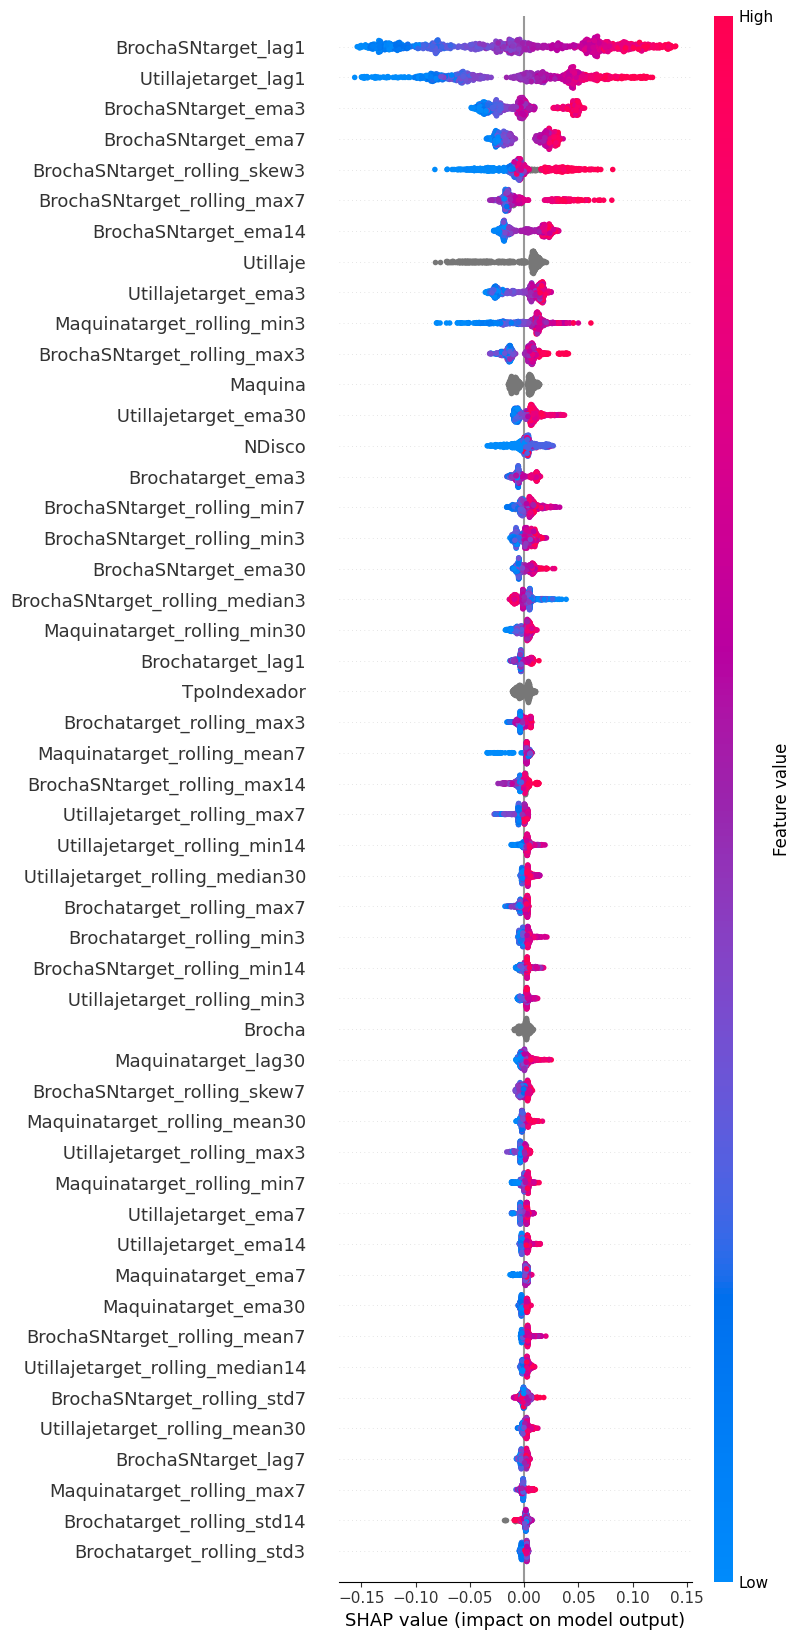

In [32]:
import shap

explainer = shap.TreeExplainer(model.estimators[-1]['lgbm'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, X_test.columns, plot_size=0.3, max_display=50)

Predicted  0.2145 True:-0.8630
Max abs  1.0775


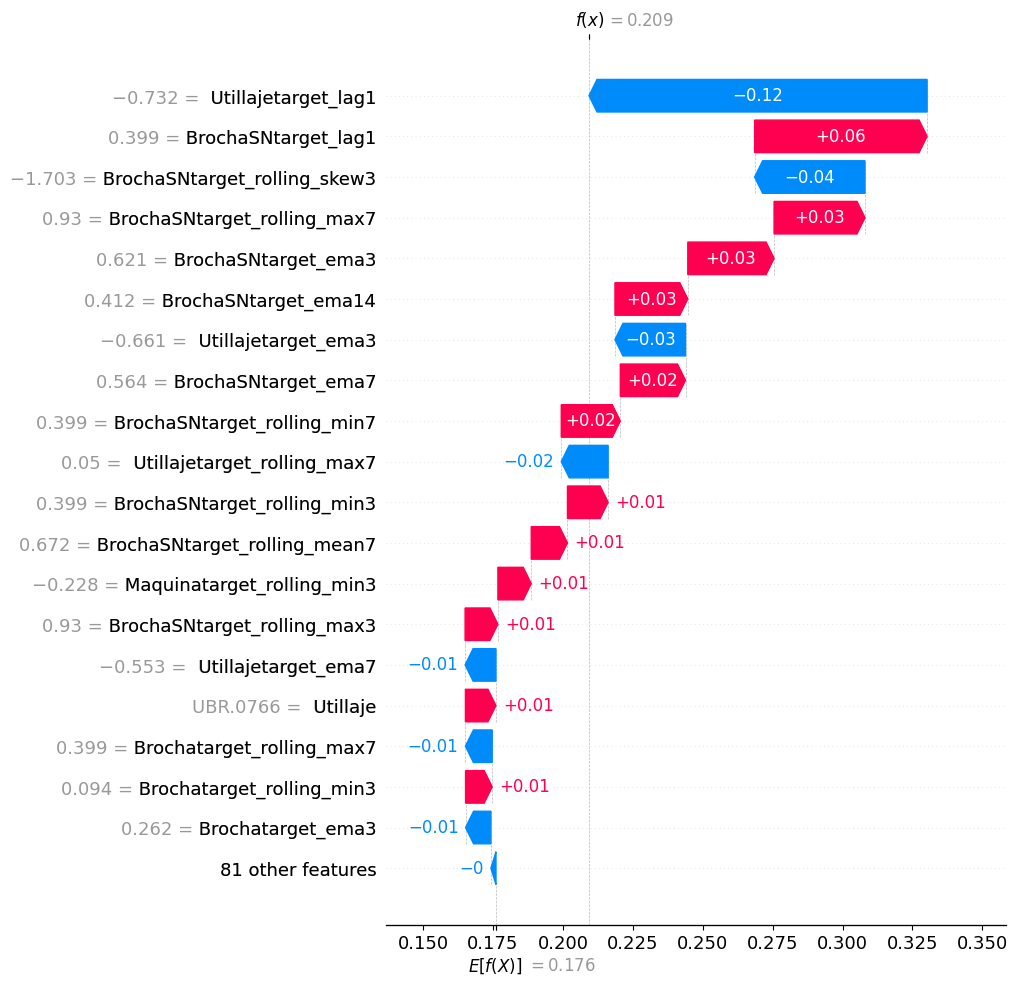

BrochaSNtarget_lag1                   0.399
 Utillajetarget_lag1                 -0.732
BrochaSNtarget_ema7                0.564046
BrochaSNtarget_rolling_skew3      -1.703413
 Utillaje                          UBR.0766
                                     ...   
 Utillajetarget_rolling_std14      0.198615
 Utillajetarget_rolling_median7      -0.574
Maquinatarget_ema3                 0.016714
Brochatarget_rolling_kurtosis30    0.805652
Brochatarget_rolling_min14           -0.035
Name: 732, Length: 100, dtype: object

In [33]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# compute SHAP values
explainer = shap.Explainer(model.estimators[-1]['lgbm'], feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test)

index = 732

print(f"Predicted {y_pred[index]: .4f} True:{y_test[index]: .4f}")
print(f"Max abs {y_pred[index] - y_test[index]: .4f}")

shap.plots.waterfall(shap_values[index], max_display=20)
X_test.iloc[index]

In [34]:
shap_values = explainer.shap_values(X_test)
# Calculate mean and max absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
print()
max_abs_shap = np.abs(shap_values).max(axis=0)

# Create a DataFrame with feature names and their corresponding mean and max absolute SHAP values
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': mean_abs_shap,
    'max_abs_shap': max_abs_shap
})

# Sort by mean absolute SHAP values (descending order)
feature_importance_mean = feature_importance.sort_values('mean_abs_shap', ascending=False)


# Sort by max absolute SHAP values (descending order)
feature_importance_max = feature_importance.sort_values('max_abs_shap', ascending=False)

feature_importance_mean.feature[:200].values

array(['BrochaSNtarget_lag1', ' Utillajetarget_lag1',
       'BrochaSNtarget_ema3', 'BrochaSNtarget_ema7',
       'BrochaSNtarget_rolling_skew3', 'BrochaSNtarget_rolling_max7',
       'BrochaSNtarget_ema14', ' Utillaje', ' Utillajetarget_ema3',
       'Maquinatarget_rolling_min3', 'BrochaSNtarget_rolling_max3',
       'Maquina', ' Utillajetarget_ema30', 'NDisco', 'Brochatarget_ema3',
       'BrochaSNtarget_rolling_min7', 'BrochaSNtarget_rolling_min3',
       'BrochaSNtarget_ema30', 'BrochaSNtarget_rolling_median3',
       'Maquinatarget_rolling_min30', 'Brochatarget_lag1', 'TpoIndexador',
       'Brochatarget_rolling_max3', 'Maquinatarget_rolling_mean7',
       'BrochaSNtarget_rolling_max14', ' Utillajetarget_rolling_max7',
       ' Utillajetarget_rolling_min14',
       ' Utillajetarget_rolling_median30', 'Brochatarget_rolling_max7',
       'Brochatarget_rolling_min3', 'BrochaSNtarget_rolling_min14',
       ' Utillajetarget_rolling_min3', 'Brocha', 'Maquinatarget_lag30',
       'Brocha